<a href="https://colab.research.google.com/github/ChethanaVaisali/COVID_19/blob/master/COVID_19_squeezenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SqueezeNet For COVID-19**

### Import data

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
import keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Add, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import GlobalMaxPool2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers, optimizers

Using TensorFlow backend.


In [2]:
import numpy as np

train_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/train1_x.npy')
train_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/train1_y.npy')

valid_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/valid1_x.npy')
valid_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/valid1_y.npy')

test_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/test1_x.npy')
test_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/test1_y.npy')

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(4470, 227, 227, 3) (4470,)
(1168, 227, 227, 3) (1168,)
(465, 227, 227, 3) (465,)


In [5]:
## Convert y to one hot encoding

train_y = keras.utils.to_categorical(train_y)
valid_y = keras.utils.to_categorical(valid_y)
test_y = keras.utils.to_categorical(test_y)

print(train_y.size, valid_y.size, test_y.size)

13410 3504 1395


In [6]:
!pip install git+https://github.com/rcmalli/keras-squeezenet.git
!pip install keras_squeezenet

  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-k5jvxkfa
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-k5jvxkfa
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-cp36-none-any.whl size=4425 sha256=820935fb57086cb629556bbf20bd38f6a7226ef75cd8359334ac795c12c9a2ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbehfpsh/wheels/15/75/ed/45fffbc76d921a5be07af533b774b35bbf40551334c51af91f
Successfully built keras-squeezenet


In [7]:
# Import model
from keras_squeezenet import SqueezeNet
sn_model = SqueezeNet(include_top = False, weights='imagenet',input_shape=(227,227,3))
sn_model.summary()

3039232/3032184 [==============================] - 1s 0us/step
Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           relu_conv1[0][0]                 
__________________________

In [8]:
# The addition of top layers
x = Flatten()(sn_model.layers[-1].output)
x = Dense(256, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dense(256, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dense(3, activation = 'softmax')(x)
model = Model(inputs = sn_model.input, outputs = x)

for layer in sn_model.layers:
  layer.trainable = False

for layer in sn_model.layers:
  if"BatchNormalization" in layer.__class__.__name__:
    layer.trainable = True

model.compile(optimizer= optimizers.SGD(lr=0.0003, decay=1e-6, momentum=0.9, nesterov=True) , loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           relu_conv1[0][0]                 
____________________________________________________________________________________________

In [50]:
mc = ModelCheckpoint('/gdrive/My Drive/Colab Notebooks/squeezenet.h5',monitor='val_loss', save_best_only = True, verbose = 1, mode='min')
es = EarlyStopping(monitor='val_loss', mode = 'min',patience = 15, verbose=1)
lr = ReduceLROnPlateau(factor=0.1, patience = 5, min_lr = 0.0000001, verbose = 1)
history = model.fit(train_x, train_y, batch_size = 64, epochs = 100, validation_data=(valid_x,valid_y), shuffle = True, callbacks = [es,lr, mc])

Train on 4470 samples, validate on 1168 samples
Epoch 1/100
4470/4470 [==============================] - 9s 2ms/step - loss: 5.3265 - accuracy: 0.9714 - val_loss: 5.4893 - val_accuracy: 0.9272

Epoch 00001: val_loss improved from inf to 5.48931, saving model to /gdrive/My Drive/Colab Notebooks/squeezenet.h5
Epoch 2/100
4470/4470 [==============================] - 9s 2ms/step - loss: 5.3242 - accuracy: 0.9725 - val_loss: 5.4874 - val_accuracy: 0.9281

Epoch 00002: val_loss improved from 5.48931 to 5.48744, saving model to /gdrive/My Drive/Colab Notebooks/squeezenet.h5
Epoch 3/100
4470/4470 [==============================] - 9s 2ms/step - loss: 5.3232 - accuracy: 0.9723 - val_loss: 5.4867 - val_accuracy: 0.9281

Epoch 00003: val_loss improved from 5.48744 to 5.48669, saving model to /gdrive/My Drive/Colab Notebooks/squeezenet.h5
Epoch 4/100
4470/4470 [==============================] - 9s 2ms/step - loss: 5.3229 - accuracy: 0.9727 - val_loss: 5.4864 - val_accuracy: 0.9289

Epoch 00004: va

<Figure size 432x288 with 0 Axes>

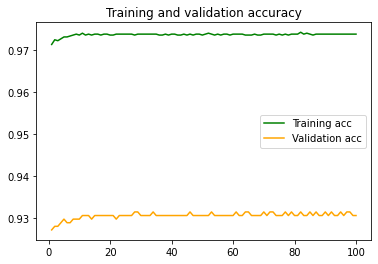

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc, 'b', color='green', label = 'Training acc')
plt.plot(epochs,val_acc, 'b', color='orange', label = 'Validation acc')

plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

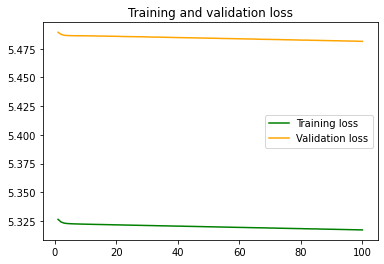

In [52]:
plt.plot(epochs, loss, 'b', color='green', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', color='orange', label = 'Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [9]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/squeezenet.h5')
model.evaluate(train_x,train_y)

4470/4470 [==============================] - 13s 3ms/step


[5.317285267832029, 0.9738255143165588]

In [10]:
model.evaluate(valid_x,valid_y)

1168/1168 [==============================] - 2s 2ms/step


[5.481382167502625, 0.9306507110595703]

In [11]:
model.evaluate(test_x,test_y)

465/465 [==============================] - 1s 2ms/step


[5.697024239775955, 0.8645161390304565]

In [0]:
pred = model.predict(test_x)

(465,) (465,)


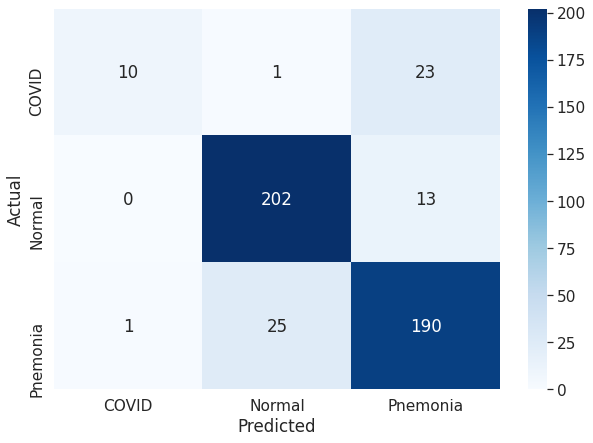

In [29]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

y = np.argmax(test_y,axis = 1)
pred_y = np.argmax(pred,axis = 1)
print(y.shape,pred_y.shape)
data = confusion_matrix(y,pred_y)
df = pd.DataFrame(data, columns = ['COVID','Normal','Pnemonia'], index = ['COVID','Normal','Pnemonia'])
df.index.name = 'Actual'
df.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale = 1.4)
sns.heatmap(df, cmap = 'Blues', annot = True, fmt = "d")